In [2]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Create constants
NPZ_DIR = '/content/drive/My Drive/Summer 2025/ESC-50 Water Project/audio/npz_files'

In [5]:
def load_and_prepare_data(file_path):
    """
    Loads data from a single .npz file and prepares the data to be in the correct
    shape for the models. Pads MFCCs to a uniform length, flattens them into
    feature vectors, then applies scaling.

    Args:
        file_path (str): The path to the .npz file.

    Returns:
        tuple: A tuple containing the prepared mfcc features and labels
    """

    # Load data from the .npz file
    data = np.load(file_path, allow_pickle=True)
    mfcc_segments = data['mfcc']
    labels = data['labels']

    # Pad all segments to the same length
    max_frames = 0
    # find the largest segment
    for segment in mfcc_segments:
        if segment.shape[0] > max_frames:
            max_frames = segment.shape[0]

    padded_segments = []
    # Now apply the padding
    for segment in mfcc_segments:
        if segment.shape[0] < max_frames:
            # Pad the shorter segments with zeros
            padding_needed = max_frames - segment.shape[0]
            padded_segment = np.pad(segment, ((0, padding_needed), (0, 0)), mode='constant')
            padded_segments.append(padded_segment)
        else:
            # already the max length
            padded_segments.append(segment)

    # Convert to a single 3D numpy array
    X = np.array(padded_segments)
    y = np.array(labels)

    # Reshape from (num_samples, frames, mfccs) to (num_samples, frames * mfccs)
    # this is the shape many models expect
    n_samples, n_frames, n_mfccs = X.shape
    X_flattened = X.reshape(n_samples, -1)

    # Scale the features for normalization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flattened)

    return X_scaled, y

In [6]:
def run_single_npz_experiment(file_path,  model_type='lr_cpu'):
    """
    Loads, prepares, and evaluates the model for a single .npz file using the
    specified model type. Uses 5-fold cross-validation.

    Args:
        file_path (str): The path to the .npz file
        model_type (str): the specified model

    Returns:
        avg_accuracy (float): the average accuracy for the model
    """

    filename = os.path.basename(file_path)
    print(f"--- Testing {model_type} on: {filename} ---")

    # Load and prepare the data
    X, y = load_and_prepare_data(file_path)

    # Choose the correct model
    if model_type == 'lr_cpu':
        model = LogisticRegression(max_iter=1000, n_jobs=-1)
    elif model_type == 'lgbm':
        model = lgb.LGBMClassifier(verbosity=-1)
    else:
        # user gave invalid input
        raise ValueError("Unknown model_type specified")

    # Run 5-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        score = model.score(X_val, y_val)
        scores.append(score)

    avg_accuracy = np.mean(scores)
    print(f"  Average Accuracy for {model_type}: {avg_accuracy:.4f}\n")
    return avg_accuracy

In [ ]:
# Get a list of all .npz files to test
all_npz_files = []
for f in sorted(os.listdir(NPZ_DIR)):
    if f.endswith('.npz'):
        all_npz_files.append(os.path.join(NPZ_DIR, f))

print(f"Found {len(all_npz_files)} .npz files to test.\n")

#   --- Run Logistic Regression Tests ---
lr_results = {}
print("Starting Logistic Regression Tests")
for file_path in all_npz_files:
    filename = os.path.basename(file_path)
    lr_results[filename] = run_single_npz_experiment(file_path, model_type='lr_cpu')
print("--- All tests are complete! ---")

Found 147 .npz files to test.

Starting Logistic Regression Tests
--- Testing lr_cpu on: esc50_mfcc_n128_fft1024_ovlp25_seg1000ms.npz ---
  Average Accuracy for lr_cpu: 0.6698

--- Testing lr_cpu on: esc50_mfcc_n128_fft1024_ovlp25_seg100ms.npz ---
  Average Accuracy for lr_cpu: 0.6914

--- Testing lr_cpu on: esc50_mfcc_n128_fft1024_ovlp25_seg2000ms.npz ---
  Average Accuracy for lr_cpu: 0.6833

--- Testing lr_cpu on: esc50_mfcc_n128_fft1024_ovlp25_seg200ms.npz ---


KeyboardInterrupt: 

In [ ]:
# Run experiments for LightGBM
lgbm_results = {}
print("\\nStarting LightGBM Tests...")
for file_path in all_npz_files:
    filename = os.path.basename(file_path)
    lgbm_results[filename] = run_single_npz_experiment(file_path, model_type='lgbm')

print("--- All tests are complete! ---")

In [ ]:
# Convert both result dictionaries to pandas Series
lr_series = pd.Series(lr_results, name='LR_Accuracy')
lgbm_series = pd.Series(lgbm_results, name='LGBM_Accuracy')

# Combine them into a single DataFrame
final_results_df = pd.concat([lr_series, lgbm_series], axis=1)

# Sort by the best-performing model (LGBM) to see the top configurations
final_results_df.sort_values(by='LGBM_Accuracy', ascending=False, inplace=True)


# Display the results
print("Final Results Summary")
with pd.option_context('display.precision', 4):
    display(final_results_df)

NameError: name 'lgbm_results' is not defined

In [ ]:
pd.set_option('display.max_rows', None)
print(final_results_df.to_markdown())

In [ ]:
# Convert both result dictionaries to pandas Series
lr_series = pd.Series(lr_results, name='LR_Accuracy')
lgbm_series = pd.Series(lgbm_results, name='LGBM_Accuracy')

# Combine them into a single DataFrame
final_results_df = pd.concat([lr_series, lgbm_series], axis=1)

# Sort by the best-performing model (LGBM) to see the top configurations
final_results_df.sort_values(by='LR_Accuracy', ascending=False, inplace=True)


# Display the results
print("Final Results Summary")
with pd.option_context('display.precision', 4):
    display(final_results_df)

In [9]:
NPZ_FILE = os.path.join(NPZ_DIR, 'esc50_mfcc_n64_fft2048_ovlp50_seg25ms_new.npz')

In [10]:
# run a single test
run_single_npz_experiment(NPZ_FILE, model_type='lr_cpu')

--- Testing lr_cpu on: esc50_mfcc_n64_fft2048_ovlp50_seg25ms_new.npz ---
  Average Accuracy for lr_cpu: 0.6728



np.float64(0.672800925925926)

In [ ]:
run_single_npz_experiment(NPZ_FILE, model_type='lgbm')

--- Testing lgbm on: esc50_mfcc_n64_fft2048_ovlp50_seg25ms_new.npz ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Average Accuracy for lgbm: 0.8960



np.float64(0.8959876543209877)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


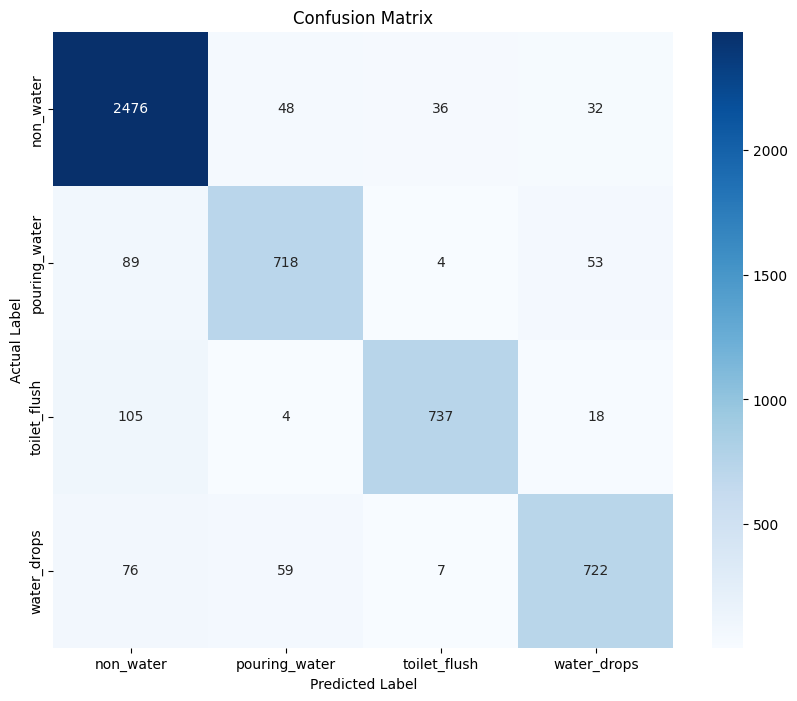

In [ ]:
# Load and prepare data
X, y = load_and_prepare_data(NPZ_FILE)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Make and train the model
model = lgb.LGBMClassifier(verbosity=-1)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Confusion Matrix
class_names = ['non_water', 'pouring_water', 'toilet_flush', 'water_drops']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
# Seaborn's heatmap for visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
# run a single test
NPZ_FILE = os.path.join(NPZ_DIR, 'esc50_mfcc_n64_fft2048_ovlp50_seg25ms_natural.npz')
run_single_npz_experiment(NPZ_FILE, model_type='lr_cpu')

--- Testing lr_cpu on: esc50_mfcc_n64_fft2048_ovlp50_seg25ms_natural.npz ---
  Average Accuracy for lr_cpu: 0.6592



np.float64(0.6592129629629631)

In [14]:
run_single_npz_experiment(NPZ_FILE, model_type='lgbm')

--- Testing lgbm on: esc50_mfcc_n64_fft2048_ovlp50_seg25ms_natural.npz ---


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Average Accuracy for lgbm: 0.9298



np.float64(0.9297916666666666)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


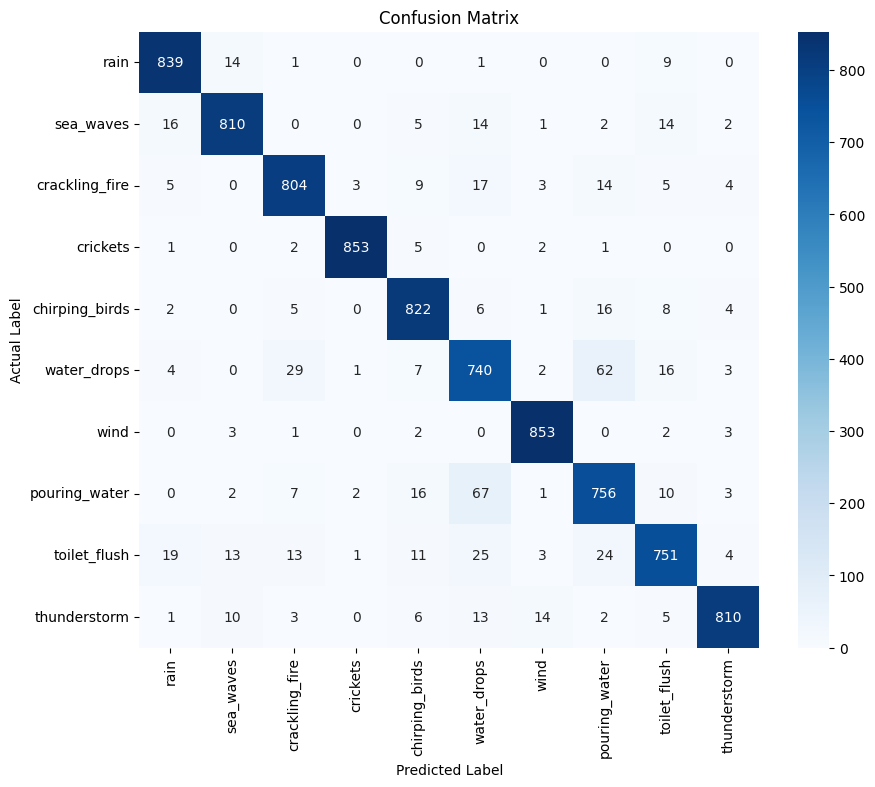

In [15]:
# Load and prepare data
X, y = load_and_prepare_data(NPZ_FILE)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Make and train the model
model = lgb.LGBMClassifier(verbosity=-1)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Confusion Matrix
class_names = ['rain', 'sea_waves', 'crackling_fire', 'crickets', 'chirping_birds',
              'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
# Seaborn's heatmap for visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [17]:
# Test space of lgbm
import joblib
from sklearn.datasets import make_classification

# train the model
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# save the trained model details to an object file
model_filename = "lgbm_model.joblib"
joblib.dump(model, model_filename)

# get info
file_size_bytes = os.path.getsize(model_filename)
file_size_kb = file_size_bytes / 1024
file_size_mb = file_size_kb / 1024

print("\nModel Size")
print(f"Size: {file_size_bytes} Bytes")
print(f"Size: {file_size_kb:.2f} KB")
print(f"Size: {file_size_mb:.4f} MB")

# Clean up the created file
os.remove(model_filename)


Model Size
Size: 3478564 Bytes
Size: 3397.04 KB
Size: 3.3174 MB


In [18]:
# used to monitor memory consumption
!pip install memory-profiler

In [19]:
# use "magic command" to write the contents of this cell to a new file
%%writefile model_trainer.py
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

def train_lgbm_model(X_train, y_train):
    """
    Initializes and trains a LightGBM model. Isolated into its own file so that
    memory-profiler can track its memory usage effectively
    """
    print("training the model...")
    model = lgb.LGBMClassifier()
    model.fit(X_train, y_train)
    print("Training complete.")
    return model

Writing model_trainer.py


In [20]:
# Load the memory-profiler extension
%load_ext memory_profiler

# Import the function from the file previously created
from model_trainer import train_lgbm_model


# Run memory profiler on the training function to measure peak RAM usage
# %mprun: The magic command to run memory profiler
# -f train_lgbm_model: specifies which function to profile
# train_lgbm_model(X_train, y_train): call to the function that will be executed and profiled
%mprun -f train_lgbm_model train_lgbm_model(X_train, y_train)

training the model...
Training complete.

